<a href="https://colab.research.google.com/github/jiyoung37/oct24_bds_int_plant_recognition/blob/main/New_plant_disease_kaggle_Model_JY_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

**1.1 Import kagglehub and download dataset**

In [ ]:
!pip install kagglehub
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [02:02<00:00, 23.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


**1.2 Define the paths**

In [ ]:
import os

# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

# Count the number of folders in a directory
def count_folders(path):
    if os.path.exists(path):
        return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Count the number of files in a directory
def count_files(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Function to count files in each folder of a given directory
def count_files_in_folders(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return {}

    folder_file_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder] = file_count

    return folder_file_counts

# Print counts
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Number of folders in valid_path: {count_folders(valid_path)}")
print(f"Number of files in test_path: {count_files(test_path)}")
print('-------------------------------------------------------------------')
# Count files in each folder
train_folder_counts = count_files_in_folders(train_path)
valid_folder_counts = count_files_in_folders(valid_path)
# Display results
print("Files in each folder (train_path):")
for folder, count in train_folder_counts.items():
    print(f"{folder}: {count} files")

print("\nFiles in each folder (valid_path):")
for folder, count in valid_folder_counts.items():
    print(f"{folder}: {count} files")

Number of folders in train_path: 38
Number of folders in valid_path: 38
Number of files in test_path: 33
-------------------------------------------------------------------
Files in each folder (train_path):
Soybean___healthy: 2022 files
Potato___healthy: 1824 files
Cherry_(including_sour)___Powdery_mildew: 1683 files
Grape___Black_rot: 1888 files
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 files
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 files
Blueberry___healthy: 1816 files
Grape___healthy: 1692 files
Cherry_(including_sour)___healthy: 1826 files
Grape___Esca_(Black_Measles): 1920 files
Corn_(maize)___Common_rust_: 1907 files
Strawberry___Leaf_scorch: 1774 files
Raspberry___healthy: 1781 files
Tomato___Leaf_Mold: 1882 files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 files
Tomato___Bacterial_spot: 1702 files
Apple___healthy: 2008 files
Corn_(maize)___healthy: 1859 files
Tomato___Early_blight: 1920 files
Corn_(maize)___Northern_Leaf_Blight: 1908 files
Tomato___Late

# 2. Importing necessary libraries for Modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

import tensorflow as tf
# Check GPU availability
if tf.config.list_physical_devices('GPU'):
    print("OK! GPU is available and ready for use!")
else:
    print("NO! GPU not found. Falling back to CPU.")

import PIL
import scipy

print(PIL.__version__)
print(scipy.__version__)

OK! GPU is available and ready for use!
11.0.0
1.13.1


# 3. Train dataset reduction (by Ji)

In [ ]:
import os
import random
import shutil

# Paths
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"
data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

train_subset_path = os.path.join(data_dir, 'train_subset')

# Define the total number of images you want in the reduced training subset
total_train_images = 20000

# Function to clear directory contents
def clear_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)  # Remove the directory and its contents
    os.makedirs(path, exist_ok=True)  # Recreate the empty directory

# Function to create reduced training subset with folder name alignment
def reduce_train_dataset(src_dir, dest_dir, total_images):
    clear_directory(dest_dir)  # Clear destination folder before copying
    classes = os.listdir(src_dir)

    # Calculate images per class based on the total required
    images_per_class = total_images // len(classes)

    for cls in classes:
        cls_src_dir = os.path.join(src_dir, cls)
        cls_dest_dir = os.path.join(dest_dir, cls)
        os.makedirs(cls_dest_dir, exist_ok=True)

        # Get all images in the class folder
        images = os.listdir(cls_src_dir)
        random.shuffle(images)

        # Select a subset of images
        selected_images = images[:images_per_class]

        for img in selected_images:
            src_path = os.path.join(cls_src_dir, img)
            dest_path = os.path.join(cls_dest_dir, img)
            shutil.copy(src_path, dest_path)

# Create reduced training subset and ensure folder names match
reduce_train_dataset(train_path, train_subset_path, total_train_images)

# Count files in each folder
reduced_train_folder_counts = count_files_in_folders(train_subset_path)
train_folder_counts = count_files_in_folders(train_path)
# Calculate the total number of images
total_images_in_train_subset = sum(reduced_train_folder_counts.values())
total_images_in_train = sum(train_folder_counts.values())
# Display results
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Total number of images in train_path: {total_images_in_train}")
print('\n')
print(f"Number of folders in reduced_train_path: {count_folders(train_subset_path)}")
print(f"Total number of images in reduced_train_path: {total_images_in_train_subset}")
print('\n')
print("Files in each folder (reduced_train_path):")
for folder, count in reduced_train_folder_counts.items():
    print(f"{folder}: {count} files")

Number of folders in train_path: 38
Total number of images in train_path: 70295


Number of folders in reduced_train_path: 38
Total number of images in reduced_train_path: 19988


Files in each folder (reduced_train_path):
Soybean___healthy: 526 files
Potato___healthy: 526 files
Cherry_(including_sour)___Powdery_mildew: 526 files
Grape___Black_rot: 526 files
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 526 files
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 526 files
Blueberry___healthy: 526 files
Grape___healthy: 526 files
Cherry_(including_sour)___healthy: 526 files
Grape___Esca_(Black_Measles): 526 files
Corn_(maize)___Common_rust_: 526 files
Strawberry___Leaf_scorch: 526 files
Raspberry___healthy: 526 files
Tomato___Leaf_Mold: 526 files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 526 files
Tomato___Bacterial_spot: 526 files
Apple___healthy: 526 files
Corn_(maize)___healthy: 526 files
Tomato___Early_blight: 526 files
Corn_(maize)___Northern_Leaf_Blight: 526 files
Tomato___Late_blig

# Model 1: CNN with 2x Conv2D

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Define paths
train_path = train_path #train_subset_path
valid_path = valid_path

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Build the CNN model with 2x Conv2D
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(38, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

val_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

# Visualize training performance
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 698s 315ms/step - accuracy: 0.2185 - loss: 2.9908 - val_accuracy: 0.5692 - val_loss: 1.7344
Epoch 2/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1s 203us/step - accuracy: 0.3750 - loss: 2.0462 - val_accuracy: 0.5000 - val_loss: 4.7209
Epoch 3/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 699s 317ms/step - accuracy: 0.4204 - loss: 2.1399 - val_accuracy: 0.6490 - val_loss: 1.4318
Epoch 4/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - accuracy: 0.4375 - loss: 1.7163 - val_accuracy: 0.5000 - val_loss: 1.6594
Epoch 5/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 697s 316ms/step - accuracy: 0.4989 - loss: 1.8623 - val_accuracy: 0.6726 - val_loss: 1.3956
Epoch 6/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - accuracy: 0.6562 - loss: 1.1301 - val_accuracy: 0.2500 - val_loss: 4.2059
Epoch 7/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 698s 317ms/step - accuracy: 0.5395 - loss: 1.6969 - val_accuracy: 0.6991 - v

KeyboardInterrupt: 

Plot accuracies & loss over epochs

In [ ]:
fig= plt.figure(figsize=(8,4))
fig.suptitle('Performance: CNN-5', fontsize=15)

# Plot accuracy
plt.subplot(121)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Model accuracy by epoch')
plt.xlabel('Epochs')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(122)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model loss by epoch')
plt.xlabel('Epochs')
plt.ylim([0,2])
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

Classification report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
# Generate predictions for validation set
val_pred = model.predict(val_generator)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(true_classes, val_pred_classes)
print("Classification Report:\n", class_report)

# Model 2: CNN with 3x Conv2D

In [ ]:
# Define paths
# if you want use 20k train dataset -> train_subset_path
# if you want use original train dataset -> train_path
train_path =  train_subset_path #train_subset_path #train_path
valid_path = valid_path

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

val_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ]

# Build the CNN model with 2x Conv2D
model = Sequential([
    Input(shape=(224, 224, 3)), # manual IMG_SIZE
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

# Visualize training performance
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Found 19988 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 79s 113ms/step - accuracy: 0.3073 - loss: 2.8558 - val_accuracy: 0.6277 - val_loss: 1.3204
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5000 - loss: 2.0815 - val_accuracy: 0.7500 - val_loss: 0.5905
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.6653 - loss: 1.1439 - val_accuracy: 0.7880 - val_loss: 0.7317
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7188 - loss: 0.9782 - val_accuracy: 1.0000 - val_loss: 0.0295
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.7762 - loss: 0.7396 - val_accuracy: 0.8137 - val_loss: 0.6189
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8438 - loss: 0.4485 - val_accuracy: 1.0000 - val_loss: 0.0208
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8458 - loss: 0.4988 - val_accuracy: 0.8375 - val_loss: 0.5442
Epoch 8

Plot accuracies & loss over epochs

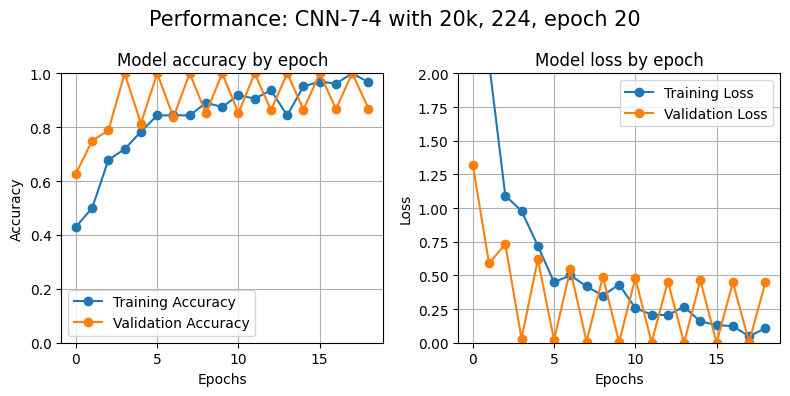

In [ ]:
fig= plt.figure(figsize=(8,4))
fig.suptitle('Performance: CNN-7-4 with 20k, 224, epoch 20', fontsize=15) # Change title

# Plot accuracy
plt.subplot(121)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Model accuracy by epoch')
plt.xlabel('Epochs')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(122)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model loss by epoch')
plt.xlabel('Epochs')
plt.ylim([0,2])
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Model 3: Transfer learning-VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define paths
# if you want use 20k train dataset -> train_subset_path
# if you want use original train dataset -> train_path
train_path =  train_subset_path #train_subset_path #train_path
valid_path = valid_path

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

# Load VGG16 without the top layer, use pretrained ImageNet weights
vgg16_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base layers
for layer in vgg16_base.layers[-4:]:
    layer.trainable = True

# Define the transfer learning model
model = Sequential([
    vgg16_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_vgg16_model.keras", save_best_only=True),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=2,
        min_lr=1e-6)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
)

# Visualize training performance
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

Found 19988 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 473s 683ms/step - accuracy: 0.0271 - loss: 3.6392 - val_accuracy: 0.0939 - val_loss: 3.3927 - learning_rate: 1.0000e-04
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0938 - loss: 3.2655 - val_accuracy: 0.0000e+00 - val_loss: 3.5343 - learning_rate: 1.0000e-04
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 393s 629ms/step - accuracy: 0.1428 - loss: 3.0815 - val_accuracy: 0.6543 - val_loss: 1.2226 - learning_rate: 1.0000e-04
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 70us/step - accuracy: 0.5312 - loss: 1.6473 - val_accuracy: 0.7500 - val_loss: 1.4049 - learning_rate: 1.0000e-04
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 393s 629ms/step - accuracy: 0.6074 - loss: 1.2892 - val_accuracy: 0.8551 - val_loss: 0.4874 - learning_rate: 1.0000e-04
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.6640 - val_accuracy: 0.7500 - val_

Save model

In [ ]:
model.save("Model 3_VGG16_v2 with 20k, 224, epoch 20.keras")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/DataScientist_Projects"
model.save(f"{save_dir}/ Model 3_VGG16_v2 with 20k, 224, epoch 20.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plot accuracies & loss over epochs

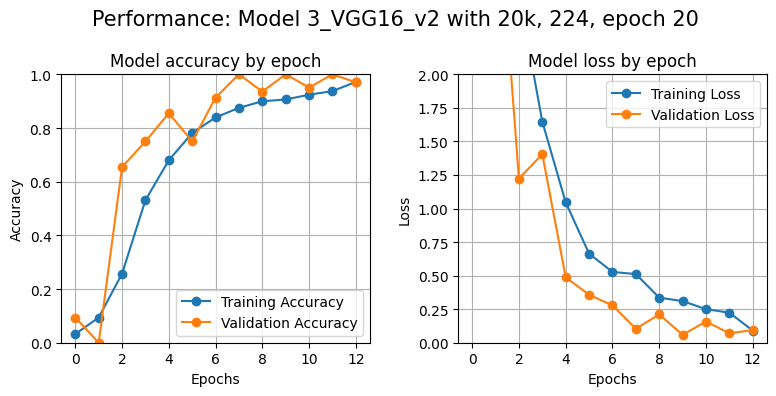

In [ ]:
fig= plt.figure(figsize=(8,4))
fig.suptitle('Performance: Model 3_VGG16_v2 with 20k, 224, epoch 20', fontsize=15) # Change title

# Plot accuracy
plt.subplot(121)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Model accuracy by epoch')
plt.xlabel('Epochs')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(122)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model loss by epoch')
plt.xlabel('Epochs')
plt.ylim([0,2])
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluation on test folder

Evaluation on the test folder by Ji

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# Define helper function to preprocess a single image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img) / 255.0               # Convert to array and rescale
    return img_array

# Load and preprocess all images from the test folder
def load_test_images(test_path, target_size):
    test_images = []
    filenames = []
    for file in os.listdir(test_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Supported file formats
            file_path = os.path.join(test_path, file)
            test_images.append(preprocess_image(file_path, target_size))
            filenames.append(file)  # Save filenames for reference
    return np.array(test_images), filenames

# Parameters
IMG_SIZE = (224, 224)  # Adjust to model's input size
test_path = test_path

# Load and preprocess test images
test_images, filenames = load_test_images(test_path, target_size=IMG_SIZE)

# Make Predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to class labels
class_labels = train_generator.class_indices
class_indices = {v: k for k, v in class_labels.items()}  # Reverse mapping of class indices
predicted_labels = [class_indices[idx] for idx in predicted_classes]

# Print predictions with filenames
for file, pred, label in zip(filenames, predictions, predicted_labels):
    confidence = np.max(pred)  # Get the highest probability (confidence score)
    print(f"{file}: {label} (Confidence: {confidence:.2f})")

# Prepare data for export
results = []
for file, pred, label in zip(filenames, predictions, predicted_labels):
    confidence = np.max(pred)  # Get the highest probability (confidence score)
    results.append({"Filename": file, "Predicted Label": label, "Confidence": confidence})

# Create a DataFrame
df_results = pd.DataFrame(results)

# Save DataFrame to CSV
output_csv_path = f"{save_dir}/predictions.csv"  # Specify the output file path
df_results.to_csv(output_csv_path, index=False)

print(f"Predictions have been saved to {output_csv_path}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
TomatoEarlyBlight2.JPG: Tomato___Early_blight (Confidence: 0.43)
TomatoHealthy2.JPG: Tomato___healthy (Confidence: 0.87)
TomatoYellowCurlVirus4.JPG: Tomato___Tomato_Yellow_Leaf_Curl_Virus (Confidence: 1.00)
TomatoYellowCurlVirus5.JPG: Tomato___Tomato_Yellow_Leaf_Curl_Virus (Confidence: 1.00)
TomatoEarlyBlight5.JPG: Tomato___Early_blight (Confidence: 0.76)
TomatoEarlyBlight1.JPG: Tomato___Late_blight (Confidence: 0.71)
TomatoHealthy4.JPG: Tomato___healthy (Confidence: 1.00)
TomatoEarlyBlight6.JPG: Tomato___Early_blight (Confidence: 0.50)
PotatoEarlyBlight4.JPG: Potato___Early_blight (Confidence: 0.93)
AppleCedarRust3.JPG: Apple___Cedar_apple_rust (Confidence: 1.00)
CornCommonRust3.JPG: Corn_(maize)___Common_rust_ (Confidence: 1.00)
PotatoHealthy2.JPG: Potato___healthy (Confidence: 1.00)
TomatoYellowCurlVirus3.JPG: Tomato___Tomato_Yellow_Leaf_Curl_Virus (Confidence: 1.00)
PotatoEarlyBlight1.JPG: Potato___Early_blight (Confidence: 1.00)
AppleScab3.JP